# M4 Benchmark

Note: The example shown in this notebook is taken from the companion book [Nonlinear System Identification and Forecasting: Theory and Practice with SysIdentPy](https://sysidentpy.org/book/0-Preface/).

The M4 dataset is a well known resource for time series forecasting, offering a wide range of data series used to test and improve forecasting methods. Created for the M4 competition organized by Spyros Makridakis, this dataset has driven many advancements in forecasting techniques.

The M4 dataset includes 100,000 time series from various fields such as demographics, finance, industry, macroeconomics, and microeconomics, which were selected randomly from the ForeDeCk database. The series come in different frequencies (yearly, quarterly, monthly, weekly, daily, and hourly), making it a comprehensive collection for testing forecasting methods.

In this case study, we will focus on the hourly subset of the M4 dataset. This subset consists of time series data recorded hourly, providing a detailed and high-frequency look at changes over time. Hourly data presents unique challenges due to its granularity and the potential for capturing short-term fluctuations and patterns.

The M4 dataset provides a standard benchmark to compare different forecasting methods, allowing researchers and practitioners to evaluate their models consistently. With series from various domains and frequencies, the M4 dataset represents real-world forecasting challenges, making it valuable for developing robust forecasting techniques. The competition and the dataset itself have led to the creation of new algorithms and methods, significantly improving forecasting accuracy and reliability.

We will present a end to end walkthrough using the M4 hourly dataset to demonstrate the capabilities of SysIdentPy. SysIdentPy offers a range of tools and techniques designed to effectively handle the complexities of time series data, but we will focus on fast and easy setup for this case. We will cover model selection and evaluation metrics specific to the hourly dataset.

By the end of this case study, you will have a solid understanding of how to use SysIdentPy for forecasting with the M4 hourly dataset, preparing you to tackle similar forecasting challenges in real-world scenarios.

### Required Packages and Versions

To ensure that you can replicate this case study, it is essential to use specific versions of the required packages. Below is a list of the packages along with their respective versions needed for running the case studies effectively.

To install all the required packages, you can create a `requirements.txt` file with the following content:

```
sysidentpy==0.4.0
datasetsforecast==0.0.8
pandas==2.2.2
numpy==1.26.0
matplotlib==3.8.4
s3fs==2024.6.1
```

Then, install the packages using:
```
pip install -r requirements.txt
```

- Ensure that you use a virtual environment to avoid conflicts between package versions.
- Versions specified are based on compatibility with the code examples provided. If you are using different versions, some adjustments in the code might be necessary.

### SysIdentPy configuration

In this section, we will demonstrate the application of SysIdentPy to the Silver box dataset.  The following code will guide you through the process of loading the dataset, configuring the SysIdentPy parameters, and building a model for mentioned system.

In [3]:
import warnings
import numpy as np
import pandas as pd
from pandas.errors import SettingWithCopyWarning
import matplotlib.pyplot as plt

from sysidentpy.model_structure_selection import FROLS, AOLS
from sysidentpy.basis_function import Polynomial
from sysidentpy.parameter_estimation import LeastSquares
from sysidentpy.metrics import (
    root_relative_squared_error,
    symmetric_mean_absolute_percentage_error,
)
from sysidentpy.utils.plotting import plot_results

from datasetsforecast.m4 import M4, M4Evaluation

warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.simplefilter(action="ignore", category=UserWarning)
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

train = pd.read_csv("https://auto-arima-results.s3.amazonaws.com/M4-Hourly.csv")
test = pd.read_csv(
    "https://auto-arima-results.s3.amazonaws.com/M4-Hourly-test.csv"
).rename(columns={"y": "y_test"})

The following plots provide a visualization of the training data for a small subset of the time series. The plot shows the raw data, giving you an insight into the patterns and behaviors inherent in each series.

By observing the data, you can get a sense of the variety and complexity of the time series we are working with. The plots can reveal important characteristics such as trends, seasonal patterns, and potential anomalies within the time series. Understanding these elements is crucial for the development of accurate forecasting models.

However, when dealing with a large number of different time series, it is common to start with broad assumptions rather than detailed individual analysis. In this context, we will adopt a similar approach. Instead of going into the specifics of each dataset, we will make some general assumptions and see how SysIdentPy handles them.

This approach provides a practical starting point, demonstrating how SysIdentPy can manage different types of time series data without too much work. As you become more familiar with the tool, you can refine your models with more detailed insights. For now, let's focus on using SysIdentPy to create the forecasts based on these initial assumptions.

Our first assumption is that there is a 24-hour seasonal pattern in the series. By examining the plots below, this seems reasonable. Therefore, we'll begin building our models with `ylag=24`.

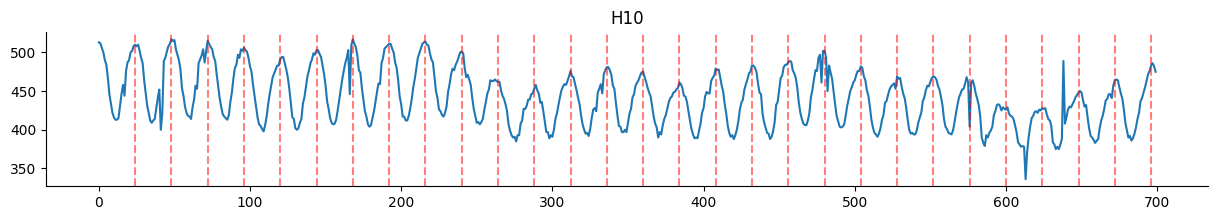

In [4]:
ax = (
    train[train["unique_id"] == "H10"]
    .reset_index(drop=True)["y"]
    .plot(figsize=(15, 2), title="H10")
)
xcoords = [a for a in range(24, 24 * 30, 24)]

for xc in xcoords:
    plt.axvline(x=xc, color="red", linestyle="--", alpha=0.5)

Lets check build a model for the `H20` group before we extrapolate the settings for every group. Because there are no input features, we will be using a `NAR` model type in SysIdentPy. To keep things simple and fast, we will start with Polynomial basis function with degree $1$.

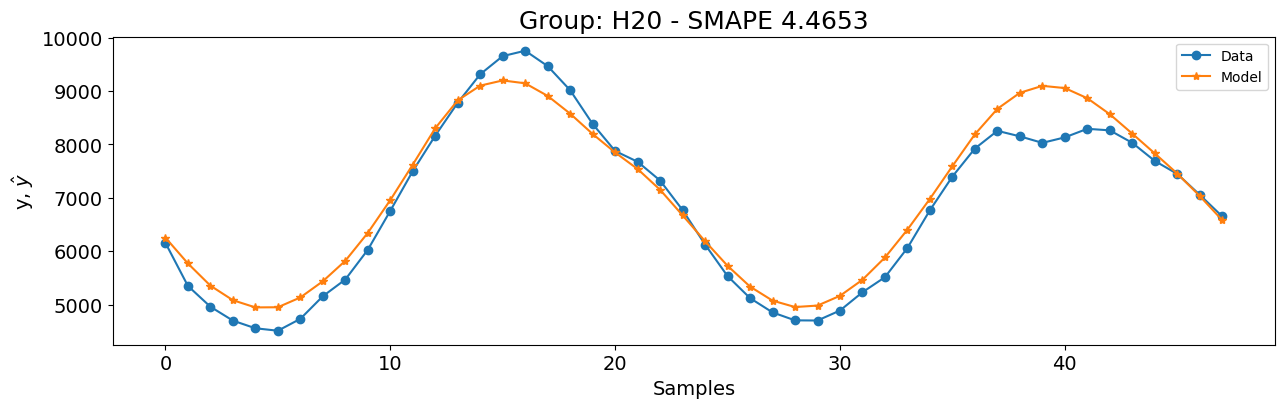

In [5]:
unique_id = "H20"
y_id = train[train["unique_id"] == unique_id]["y"].values.reshape(-1, 1)
y_val = test[test["unique_id"] == unique_id]["y_test"].values.reshape(-1, 1)

basis_function = Polynomial(degree=1)
model = FROLS(
    order_selection=True,
    ylag=24,
    estimator=LeastSquares(),
    basis_function=basis_function,
    model_type="NAR",
)

model.fit(y=y_id)
y_val = np.concatenate([y_id[-model.max_lag :], y_val])
y_hat = model.predict(y=y_val, forecast_horizon=48)
smape = symmetric_mean_absolute_percentage_error(
    y_val[model.max_lag : :], y_hat[model.max_lag : :]
)

plot_results(
    y=y_val[model.max_lag :],
    yhat=y_hat[model.max_lag :],
    n=30000,
    figsize=(15, 4),
    title=f"Group: {unique_id} - SMAPE {round(smape, 4)}",
)

Probably, the result are not optimal and will not work for every group. However, let's check how this setting performs against the winner model  [M4 time series competition](https://www.researchgate.net/publication/325901666_The_M4_Competition_Results_findings_conclusion_and_way_forward): the Exponential Smoothing with Recurrent Neural Networks ([ESRNN](https://www.sciencedirect.com/science/article/abs/pii/S0169207019301153)).

In [7]:
esrnn_url = (
    "https://github.com/Nixtla/m4-forecasts/raw/master/forecasts/submission-118.zip"
)
esrnn_forecasts = M4Evaluation.load_benchmark("data", "Hourly", esrnn_url)
esrnn_evaluation = M4Evaluation.evaluate("data", "Hourly", esrnn_forecasts)

esrnn_evaluation

,SMAPE,MASE,OWA
Hourly,9.328443,0.893046,0.440163


The following code took only 49 seconds to run on my machine (AMD Ryzen 5 5600x processor, 32GB RAM at 3600MHz). Because of its efficiency, I didn't create a parallel version. By the end of this use case, you will see how SysIdentPy can be both fast and effective, delivering good results without too much optimization.

In [8]:
r = []
ds_test = list(range(701, 749))
for u_id, data in train.groupby(by=["unique_id"], observed=True):
    y_id = data["y"].values.reshape(-1, 1)
    basis_function = Polynomial(degree=1)
    model = FROLS(
        ylag=24,
        estimator=LeastSquares(),
        basis_function=basis_function,
        model_type="NAR",
        n_info_values=25,
    )
    try:
        model.fit(y=y_id)
        y_val = y_id[-model.max_lag :].reshape(-1, 1)
        y_hat = model.predict(y=y_val, forecast_horizon=48)
        r.append(
            [
                u_id * len(y_hat[model.max_lag : :]),
                ds_test,
                y_hat[model.max_lag : :].ravel(),
            ]
        )
    except Exception:
        print(f"Problem with {u_id}")

results_1 = pd.DataFrame(r, columns=["unique_id", "ds", "NARMAX_1"]).explode(
    ["unique_id", "ds", "NARMAX_1"]
)
results_1["NARMAX_1"] = results_1["NARMAX_1"].astype(float)  # .clip(lower=10)
pivot_df = results_1.pivot(index="unique_id", columns="ds", values="NARMAX_1")
results = pivot_df.to_numpy()

M4Evaluation.evaluate("data", "Hourly", results)

,SMAPE,MASE,OWA
Hourly,16.034196,0.958083,0.636132


The initial results are reasonable, but they don't quite match the performance of `ESRNN`. These results are based solely on our first assumption. To better understand the performance, let’s examine the groups with the worst results.

![](https://github.com/wilsonrljr/sysidentpy-data/blob/4085901293ba5ed5674bb2911ef4d1fa20f3438d/book/assets/c10_m4_h147_r1.png?raw=true)

The following plot illustrates two such groups, `H147` and `H136`. Both exhibit a 24-hour seasonal pattern.

![](https://github.com/wilsonrljr/sysidentpy-data/blob/4085901293ba5ed5674bb2911ef4d1fa20f3438d/book/assets/c10_m4_seasonal_h147_1.png?raw=true)

![](https://github.com/wilsonrljr/sysidentpy-data/blob/4085901293ba5ed5674bb2911ef4d1fa20f3438d/book/assets/c10_m4_h136_seasonal_1.png?raw=true)

However, a closer look reveals an additional insight: in addition to the daily pattern, these series also show a weekly pattern. Observe how the data looks like when we split the series into weekly segments.

![](https://github.com/wilsonrljr/sysidentpy-data/blob/4085901293ba5ed5674bb2911ef4d1fa20f3438d/book/assets/c10_m4_h147_seasonal_1.png?raw=true)

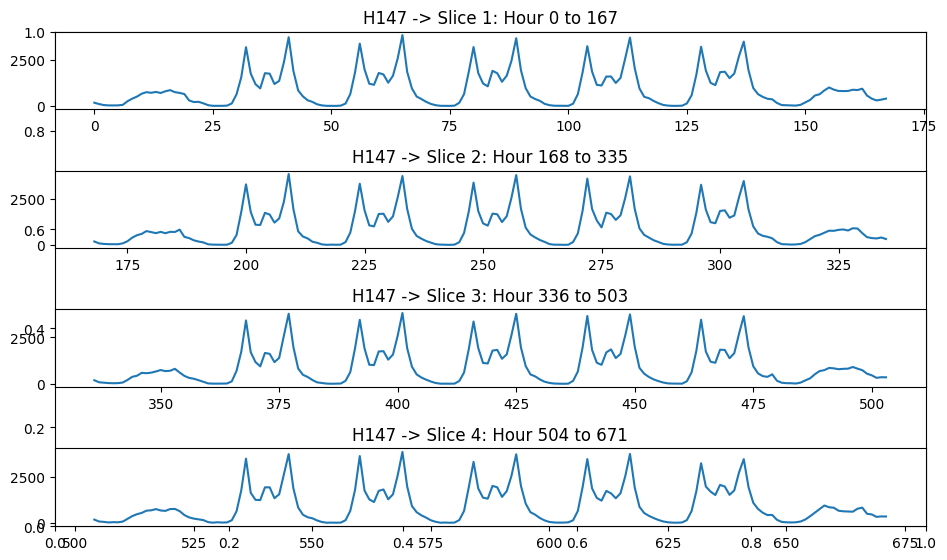

In [9]:
xcoords = list(range(0, 168 * 5, 168))
filtered_train = train[train["unique_id"] == "H147"].reset_index(drop=True)

fig, ax = plt.subplots(figsize=(10, 1.5 * len(xcoords[1:])))
for i, start in enumerate(xcoords[:-1]):
    end = xcoords[i + 1]
    ax = fig.add_subplot(len(xcoords[1:]), 1, i + 1)
    filtered_train["y"].iloc[start:end].plot(ax=ax)
    ax.set_title(f"H147 -> Slice {i+1}: Hour {start} to {end-1}")

plt.tight_layout()
plt.show()

Therefore, we will build models setting `ylag=168`.

> Note that this is a very high number for lags, so be careful if you want to try it with higher polynomial degrees because the time to run the models can increase significantly. I tried some configurations with polynomial degree equal to 2 and only took $6$ minutes to run (even less, using `AOLS`), without making the code run in parallel. As you can see, SysIdentPy can be very fast and you can make it faster by applying parallelization.

In [10]:
# this took 2min to run on my computer.
r = []
ds_test = list(range(701, 749))
for u_id, data in train.groupby(by=["unique_id"], observed=True):
    y_id = data["y"].values.reshape(-1, 1)
    basis_function = Polynomial(degree=1)
    model = FROLS(
        ylag=168,
        estimator=LeastSquares(),
        basis_function=basis_function,
        model_type="NAR",
    )
    try:
        model.fit(y=y_id)
        y_val = y_id[-model.max_lag :].reshape(-1, 1)
        y_hat = model.predict(y=y_val, forecast_horizon=48)
        r.append(
            [
                u_id * len(y_hat[model.max_lag : :]),
                ds_test,
                y_hat[model.max_lag : :].ravel(),
            ]
        )
    except Exception:
        print(f"Problem with {u_id}")

results_1 = pd.DataFrame(r, columns=["unique_id", "ds", "NARMAX_1"]).explode(
    ["unique_id", "ds", "NARMAX_1"]
)
results_1["NARMAX_1"] = results_1["NARMAX_1"].astype(float)  # .clip(lower=10)
pivot_df = results_1.pivot(index="unique_id", columns="ds", values="NARMAX_1")
results = pivot_df.to_numpy()
M4Evaluation.evaluate("data", "Hourly", results)

,SMAPE,MASE,OWA
Hourly,10.475998,0.773749,0.446471


Now, the results are much closer to those of the `ESRNN` model! While the Symmetric Mean Absolute Percentage Error (`SMAPE`) is slightly worse, the Mean Absolute Scaled Error (`MASE`) is better when comparing against `ESRNN`, leading to a very similar Overall Weighted Average (`OWA`) metric. Remarkably, these results are achieved using only simple `AR` models. Next, let's see if the `AOLS` method can provide even better results.

In [11]:
r = []
ds_test = list(range(701, 749))
for u_id, data in train.groupby(by=["unique_id"], observed=True):
    y_id = data["y"].values.reshape(-1, 1)
    basis_function = Polynomial(degree=1)
    model = AOLS(
        ylag=168,
        basis_function=basis_function,
        model_type="NAR",
        # due to high lag settings, k was increased to 6 as an initial guess
        k=6,
    )
    try:
        model.fit(y=y_id)
        y_val = y_id[-model.max_lag :].reshape(-1, 1)
        y_hat = model.predict(y=y_val, forecast_horizon=48)
        r.append(
            [
                u_id * len(y_hat[model.max_lag : :]),
                ds_test,
                y_hat[model.max_lag : :].ravel(),
            ]
        )
    except Exception:
        print(f"Problem with {u_id}")

results_1 = pd.DataFrame(r, columns=["unique_id", "ds", "NARMAX_1"]).explode(
    ["unique_id", "ds", "NARMAX_1"]
)
results_1["NARMAX_1"] = results_1["NARMAX_1"].astype(float)  # .clip(lower=10)
pivot_df = results_1.pivot(index="unique_id", columns="ds", values="NARMAX_1")
results = pivot_df.to_numpy()
M4Evaluation.evaluate("data", "Hourly", results)

,SMAPE,MASE,OWA
Hourly,9.951141,0.809965,0.439755


The Overall Weighted Average (`OWA`) is even better than that of the `ESRNN` model! Additionally, the `AOLS` method was incredibly efficient, taking only **6 seconds to run**. This combination of high performance and rapid execution makes `AOLS` a compelling alternative for time series forecasting in cases with multiple series.

Before we finish, let's verify how the performance of the `H147` model has improved with the `ylag=168` setting.

![](https://github.com/wilsonrljr/sysidentpy-data/blob/4085901293ba5ed5674bb2911ef4d1fa20f3438d/book/assets/c10_m4_h147_r2.png?raw=true)

> Based on the M4 benchmark paper, we could also clip the predictions lower than 10 to 10 and the results would be slightly better. But this is left to the user.

We could achieve even better performance with some fine-tuning of the model configuration. However, I’ll leave exploring these alternative adjustments as an exercise for the user. However, keep in mind that experimenting with different settings does not always guarantee improved results. A deeper theoretical knowledge can often lead you to better configurations and, hence, better results.